Project: Catch Joe

Goal: Create method to detect user: 0, codename: Joe

Loading packages

In [1]:
import matplotlib.pyplot as plt #ploting
import numpy as np 
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import random
from lime import lime_tabular
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
print("setup done")

setup done


Loading data

In [2]:
train = pd.read_json('/Users/lczeropski/Documents/usersessions/dataset.json')
test = pd.read_json('/Users/lczeropski/Documents/usersessions/verify.json')
print('data loaded')

data loaded


In [3]:
print(train.shape)
train

(80000, 9)


,browser,os,locale,user_id,gender,location,sites,time,date
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",09:03:00,2017-01-08
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",13:57:00,2016-10-05
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",02:06:00,2017-03-28
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",21:49:00,2017-06-25
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",00:05:00,2016-02-10
...,...,...,...,...,...,...,...,...,...
79995,Chrome,Windows 10,pt-PT,178,m,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 126}, {'site': '...",06:02:00,2016-12-30
79996,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,"[{'site': 'slack.com', 'length': 74}, {'site':...",10:27:00,2017-01-27
79997,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,"[{'site': 'vk.com', 'length': 44}, {'site': 's...",17:55:00,2017-03-13
79998,Firefox,Windows 10,ru_RU,56,m,France/Paris,"[{'site': 'lenta.ru', 'length': 82}, {'site': ...",14:17:00,2016-12-06


Train data has 80000 rows and 9 columns

In [4]:
train.columns

Index(['browser', 'os', 'locale', 'user_id', 'gender', 'location', 'sites',
       'time', 'date'],
      dtype='object')

Data contains information about:
* Browser user was using
* Operating system of user
* Machine locale
* User Id, our target Joe has Id: 0
* Gender of user
* Where user was during browsing session
* Dictonary that contains what sites user was browsing and for how long
* Time when session started
* Date of session

In [5]:
joe = train[train['user_id']==0]
joe

,browser,os,locale,user_id,gender,location,sites,time,date
77,Firefox,Windows 10,ru_RU,0,m,France/Paris,"[{'site': 'mail.google.com', 'length': 86}, {'...",10:13:00,2016-04-30
198,Chrome,Windows 10,ru_RU,0,m,USA/Chicago,"[{'site': 'youtube.com', 'length': 71}, {'site...",18:26:00,2016-11-22
200,Firefox,Windows 10,ru_RU,0,m,Canada/Toronto,"[{'site': 'mail.google.com', 'length': 140}, {...",16:57:00,2017-08-05
354,Firefox,Windows 10,ru_RU,0,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 207}, {...",03:42:00,2017-02-19
710,Firefox,Ubuntu,ru_RU,0,m,France/Paris,"[{'site': 'vk.com', 'length': 56}, {'site': 's...",19:15:00,2016-04-08
...,...,...,...,...,...,...,...,...,...
79578,Chrome,Windows 10,ru_RU,0,m,France/Paris,"[{'site': 'vk.com', 'length': 82}, {'site': 'm...",19:44:00,2016-06-10
79771,Chrome,Ubuntu,ru_RU,0,m,Canada/Toronto,"[{'site': 'mail.google.com', 'length': 124}, {...",01:53:00,2017-08-16
79918,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 80}, {'...",17:46:00,2016-12-12
79982,Chrome,Windows 10,ru_RU,0,m,USA/Chicago,"[{'site': 'vk.com', 'length': 109}, {'site': '...",02:35:00,2017-05-02


Dataframe with all of Joe's sessions


In [6]:
joe_browser = joe['browser'].unique()
joe_os = joe['os'].unique()
joe_locale = joe['locale'].unique()
joe_location = joe['location'].unique()
print("Browsers Joe is using:",joe_browser,
      "\nOperating systems Joe is using:",joe_os,
      "\nLocale of machine Joe is using:",joe_locale,
      "\nWhere was Joe while browsing the internet",joe_location)

Browsers Joe is using: ['Firefox' 'Chrome'] 
Operating systems Joe is using: ['Windows 10' 'Ubuntu'] 
Locale of machine Joe is using: ['ru_RU'] 
Where was Joe while browsing the internet ['France/Paris' 'USA/Chicago' 'Canada/Toronto']


Joe is always using Firefox or Chrome as his browser, Windows 10 or Ubuntu as his OS, his machine locale is always 'ru_RU' and he was in Paris, Chicago and Toronto.

In [7]:
dates = pd.DataFrame(joe['date'])
dates.index = dates['date']
dates.drop(['date'],axis=1,inplace=True)
dates

""
date
2016-04-30
2016-11-22
2017-08-05
2017-02-19
2016-04-08
...
2016-06-10
2017-08-16
2016-12-12


Dates of Joe sessions

Defining funtion to correct our data. Expanding sites dictonary to single columns, changing data types of time and date, replacing m in gender with 0 and f with 1

In [8]:

def fix_data(x):
    sites = pd.json_normalize(x.sites) # normalizing json to flat table
    dt=x.drop('sites',axis = 1) # creating data frame without sites
    for i in range(0,len(sites.columns)):
        dt['site'+str(i)] = pd.json_normalize(sites[i]).site #creating new column with the i-th name of a site browsed
        dt['site_len'+str(i)] = pd.json_normalize(sites[i]).length #creating new column with the length of the session of i-th site browsed
        dt['site'+str(i)].fillna('None',inplace=True) #replacing missing values with 'None'
        dt['site_len'+str(i)].fillna(0,inplace = True) #replacing missing lengths with 0
    x = dt # assigning data frame with expanded dictonary
    x["time"] = pd.to_timedelta(x["time"])
    con = x["time"].dt.components
    x["time"] = con["hours"]*60 + con["minutes"] #replacing time string as integer number of minutes passed since start of the day
    starting_date = pd.to_datetime('2016-01-01')
    x['date'] = ((pd.to_datetime(x['date'])-starting_date)/(10**10)).view(np.int64) #replacing date with int64 values 
    x["gender"].replace({'m':0,'f':1},inplace = True) # replacing gender with values 0-1      
    return x

Fixing our data with fix_data function

In [9]:
train = fix_data(train)
test = fix_data(test)

In [10]:
train.head()

,browser,os,locale,user_id,gender,location,time,date,site0,site_len0,...,site8,site_len8,site9,site_len9,site10,site_len10,site11,site_len11,site12,site_len12
0,Firefox,Ubuntu,ru_RU,105,0,USA/Chicago,543,3222720,mail.google.com,50.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
1,Firefox,Windows 8,pl-PL,11,0,USA/Chicago,837,2401920,meduza.org,40.0,...,elec44.fr,109.0,None,0.0,None,0.0,None,0.0,None,0.0
2,Chrome,Ubuntu,zh-CN,17,0,Singapore/Singapore,126,3905280,facebook.net,74.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
3,Chrome,Windows 10,pt-BR,134,1,Australia/Sydney,1309,4674240,verisign.com,111.0,...,labomedia.org,224.0,None,0.0,None,0.0,None,0.0,None,0.0
4,Firefox,Windows 10,en-SG,92,1,USA/Chicago,5,345600,live.com,79.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0


Train data with fixed columns

Defining function to futher reduce cardinality

In [11]:
columns = ['browser','os','locale','location']
def joelize(x):
    for i in columns:
        a = joe[i].unique()
        for j in (x[i].unique()):
            if j not in a:
                x[i].replace(to_replace = j,value = 'Other',inplace = True)
    

Reducing cardinality 

In [12]:
joelize(train)
joelize(test)

Dataset with reduced cardinality

In [13]:
train

,browser,os,locale,user_id,gender,location,time,date,site0,site_len0,...,site8,site_len8,site9,site_len9,site10,site_len10,site11,site_len11,site12,site_len12
0,Firefox,Ubuntu,ru_RU,105,0,USA/Chicago,543,3222720,mail.google.com,50.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
1,Firefox,Other,Other,11,0,USA/Chicago,837,2401920,meduza.org,40.0,...,elec44.fr,109.0,None,0.0,None,0.0,None,0.0,None,0.0
2,Chrome,Ubuntu,Other,17,0,Other,126,3905280,facebook.net,74.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
3,Chrome,Windows 10,Other,134,1,Other,1309,4674240,verisign.com,111.0,...,labomedia.org,224.0,None,0.0,None,0.0,None,0.0,None,0.0
4,Firefox,Windows 10,Other,92,1,USA/Chicago,5,345600,live.com,79.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,Chrome,Windows 10,Other,178,0,Other,362,3144960,vk.com,126.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
79996,Other,Other,Other,32,0,Other,627,3386880,slack.com,74.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
79997,Firefox,Ubuntu,ru_RU,0,0,USA/Chicago,1075,3775680,vk.com,44.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
79998,Firefox,Windows 10,ru_RU,56,0,France/Paris,857,2937600,lenta.ru,82.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0


Stastistic informaction about categorical columns

In [14]:
train[[cname for cname in train.columns if  
                        train[cname].dtype == "object"]].describe()

,browser,os,locale,location,site0,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,site11,site12
count,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000
unique,3,3,2,4,2147,3908,5257,7795,10994,10925,10760,10420,9656,8194,5703,2982,911
top,Chrome,Other,Other,Other,youtube.com,youtube.com,youtube.com,None,None,None,None,None,None,None,None,None,None
freq,32814,39644,76400,66019,5934,6168,5641,5272,10343,18338,28397,39477,50130,60074,68863,75058,78613


Only columns containing site name informaction still has high number of unique values

Defining function to replace every site that are not in the 'i' most viewed by Joe to 'other'

In [15]:
joe_fixed = train[train['user_id']==0]
def fix_sites(x,n):
    for i in range(0,13):
        a = joe_fixed['site'+str(i)].value_counts()[:n].index
        for j in set(x["site"+str(i)]):
            if j not in a:
                x["site"+str(i)].replace(to_replace=j,value='Other',inplace=True)

Fixing sites cardinality

In [16]:
fix_sites(train,10)
fix_sites(test,10)

Every site column now has at most 11 unique values top 10 most viewed by Joe and 'Other' for others

In [17]:
train.head()

,browser,os,locale,user_id,gender,location,time,date,site0,site_len0,...,site8,site_len8,site9,site_len9,site10,site_len10,site11,site_len11,site12,site_len12
0,Firefox,Ubuntu,ru_RU,105,0,USA/Chicago,543,3222720,mail.google.com,50.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
1,Firefox,Other,Other,11,0,USA/Chicago,837,2401920,Other,40.0,...,Other,109.0,None,0.0,None,0.0,None,0.0,None,0.0
2,Chrome,Ubuntu,Other,17,0,Other,126,3905280,Other,74.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
3,Chrome,Windows 10,Other,134,1,Other,1309,4674240,Other,111.0,...,Other,224.0,None,0.0,None,0.0,None,0.0,None,0.0
4,Firefox,Windows 10,Other,92,1,USA/Chicago,5,345600,Other,79.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0


In [18]:
train[[cname for cname in train.columns if  
                        train[cname].dtype == "object"]].describe()

,browser,os,locale,location,site0,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,site11,site12
count,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000,80000
unique,3,3,2,4,7,7,11,11,11,11,11,11,11,11,11,11,2
top,Chrome,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,None,None,None,None,None,None
freq,32814,39644,76400,66019,49922,50457,50782,59959,66270,58425,49322,39477,50130,60074,68863,75058,78613


Calculating time Joe spend on every session

In [19]:

f_nums = []
li = train[train["user_id"]==0]
li.index = list(range(0,len(li)))
for j in range(0,len(li)):
    nums = []   
    for i in range(0,13):
        
        if li['site_len'+str(i)][j]>0:
            
            nums.append(li['site_len'+str(i)][j])
    f_nums.append(sum(nums))
        

Plot of how much time Joe spend on session 

<AxesSubplot:xlabel='date'>

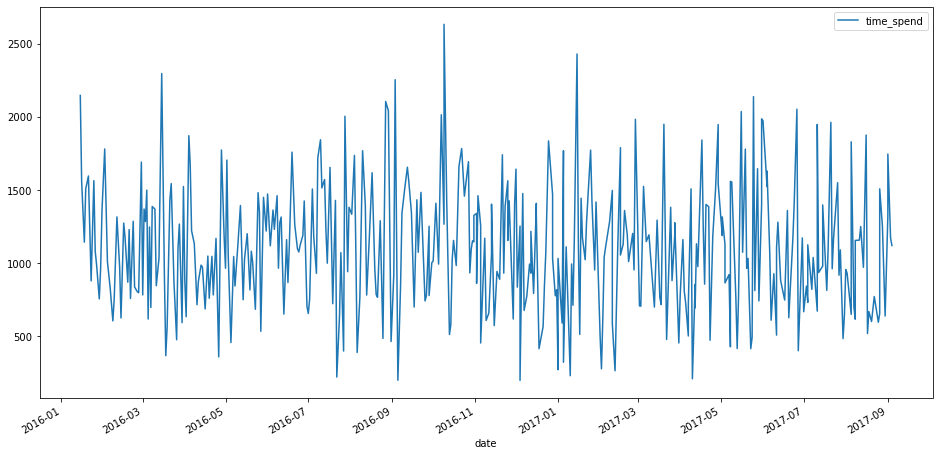

In [20]:
plt.rcParams['figure.figsize'] = [16, 8]
dates['time_spend'] = f_nums
dates.plot()

Autocorrelation plot of time Joe spend on every session in time

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

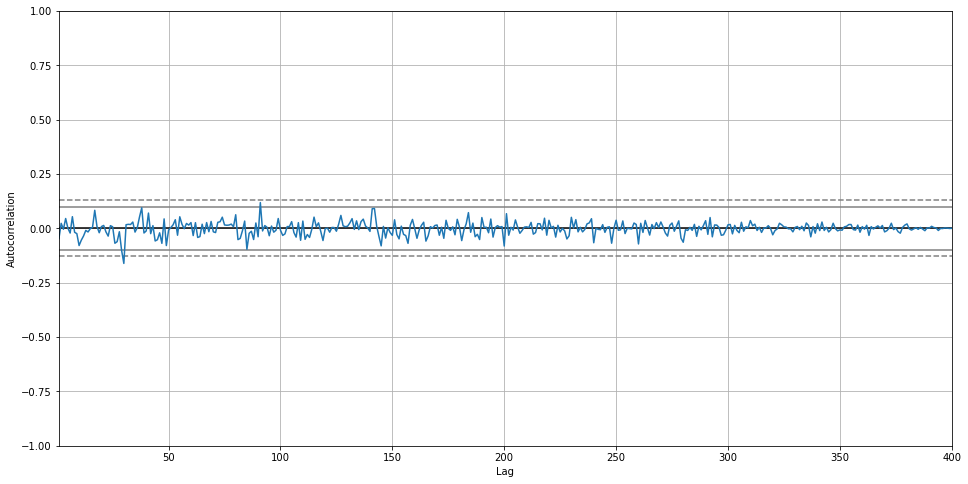

In [21]:
pd.plotting.autocorrelation_plot(dates)

There is no visible autocorrelation

Final train data

In [22]:
train.head(10)

,browser,os,locale,user_id,gender,location,time,date,site0,site_len0,...,site8,site_len8,site9,site_len9,site10,site_len10,site11,site_len11,site12,site_len12
0,Firefox,Ubuntu,ru_RU,105,0,USA/Chicago,543,3222720,mail.google.com,50.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
1,Firefox,Other,Other,11,0,USA/Chicago,837,2401920,Other,40.0,...,Other,109.0,None,0.0,None,0.0,None,0.0,None,0.0
2,Chrome,Ubuntu,Other,17,0,Other,126,3905280,Other,74.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
3,Chrome,Windows 10,Other,134,1,Other,1309,4674240,Other,111.0,...,Other,224.0,None,0.0,None,0.0,None,0.0,None,0.0
4,Firefox,Windows 10,Other,92,1,USA/Chicago,5,345600,Other,79.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
5,Other,Other,Other,120,0,France/Paris,895,3905280,Other,65.0,...,Other,354.0,None,0.0,None,0.0,None,0.0,None,0.0
6,Chrome,Ubuntu,Other,158,1,Other,1286,5106240,toptal.com,59.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
7,Chrome,Windows 10,Other,34,0,USA/Chicago,1380,423360,Other,86.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
8,Other,Other,Other,173,0,Other,1028,3188160,Other,93.0,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
9,Other,Other,Other,51,0,Other,1351,164160,Other,166.0,...,Other,123.0,None,0.0,None,0.0,None,0.0,None,0.0


Final test data

In [23]:
test.head()

,browser,os,locale,gender,location,time,date,site0,site_len0,site1,...,site8,site_len8,site9,site_len9,site10,site_len10,site11,site_len11,site12,site_len12
0,Chrome,Ubuntu,ru_RU,0,Canada/Toronto,1019,5296320,mail.google.com,383,vk.com,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
1,Chrome,Ubuntu,ru_RU,0,Canada/Toronto,1002,5313600,mail.google.com,59,vk.com,...,Other,144.0,slack.com,94.0,youtube.com,71.0,None,0.0,None,0.0
2,Firefox,Ubuntu,ru_RU,0,Canada/Toronto,1062,5330880,mail.google.com,50,vk.com,...,None,0.0,None,0.0,None,0.0,None,0.0,None,0.0
3,Chrome,Windows 10,ru_RU,0,Canada/Toronto,89,5356800,mail.google.com,153,vk.com,...,Other,403.0,Other,259.0,Other,193.0,None,0.0,None,0.0
4,Firefox,Ubuntu,ru_RU,0,Canada/Toronto,988,5365440,mail.google.com,40,vk.com,...,Other,112.0,Other,76.0,youtube.com,54.0,Other,211.0,None,0.0


Final data has more columns since we expanded sites dictonary. And because of low cardinality categorical values can be One-Hot encoded.

Assigning 'y' target for model

Removing target column from features data to avoid data leakage

In [24]:
y = train["user_id"]
y =y.apply(lambda x: 1 if x>0  else 0)
X = train.drop("user_id",axis = 1)

Spliting data for train, validation in ratio 80%, 20%

In [25]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=10,stratify=y)

Spliting features for categorical and numerical

In [26]:
cat_cols = [cname for cname in X_train_full.columns if  
                        X_train_full[cname].dtype == "object"] #columns with data type 'object'
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']] #columns with data type integer or float


Creating train and validate data for model 

In [27]:
cols = cat_cols + numerical_cols
X_train = X_train_full[cols].copy()
X_valid = X_valid_full[cols].copy()

Data for model training

In [28]:
X_train.head()

,browser,os,locale,location,site0,site1,site2,site3,site4,site5,...,site_len3,site_len4,site_len5,site_len6,site_len7,site_len8,site_len9,site_len10,site_len11,site_len12
23128,Firefox,Windows 10,Other,Other,Other,slack.com,mail.google.com,Other,Other,Other,...,315.0,93.0,44.0,228.0,78.0,218.0,81.0,0.0,0.0,0.0
22275,Chrome,Windows 10,Other,Canada/Toronto,Other,Other,Other,youtube.com,Other,Other,...,154.0,135.0,77.0,165.0,86.0,0.0,0.0,0.0,0.0,0.0
24674,Chrome,Ubuntu,Other,Other,Other,Other,Other,Other,Other,Other,...,80.0,66.0,93.0,185.0,58.0,138.0,686.0,0.0,0.0,0.0
30818,Firefox,Ubuntu,Other,Other,Other,Other,Other,Other,Other,Other,...,88.0,41.0,97.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64343,Chrome,Ubuntu,ru_RU,USA/Chicago,lenta.ru,toptal.com,vk.com,Other,youtube.com,Other,...,194.0,223.0,76.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0


Validation data

In [29]:
X_valid.head()

,browser,os,locale,location,site0,site1,site2,site3,site4,site5,...,site_len3,site_len4,site_len5,site_len6,site_len7,site_len8,site_len9,site_len10,site_len11,site_len12
34228,Other,Windows 10,Other,Other,Other,Other,Other,Other,Other,Other,...,176.0,205.0,71.0,41.0,213.0,416.0,196.0,80.0,183.0,151.0
47032,Firefox,Windows 10,Other,Other,vk.com,mail.google.com,vk.com,Other,Other,Other,...,87.0,89.0,263.0,48.0,45.0,0.0,0.0,0.0,0.0,0.0
40129,Chrome,Ubuntu,ru_RU,USA/Chicago,lenta.ru,toptal.com,vk.com,Other,Other,Other,...,176.0,210.0,99.0,197.0,106.0,80.0,91.0,0.0,0.0,0.0
55212,Chrome,Windows 10,Other,Other,Other,Other,Other,Other,Other,None,...,77.0,173.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50146,Chrome,Windows 10,ru_RU,France/Paris,mail.google.com,vk.com,toptal.com,lenta.ru,Other,slack.com,...,109.0,67.0,347.0,327.0,0.0,0.0,0.0,0.0,0.0,0.0


Test data

In [30]:
X_test = test[cols]
X_test.head()

,browser,os,locale,location,site0,site1,site2,site3,site4,site5,...,site_len3,site_len4,site_len5,site_len6,site_len7,site_len8,site_len9,site_len10,site_len11,site_len12
0,Chrome,Ubuntu,ru_RU,Canada/Toronto,mail.google.com,vk.com,toptal.com,lenta.ru,slack.com,Other,...,47.0,93.0,92.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Chrome,Ubuntu,ru_RU,Canada/Toronto,mail.google.com,vk.com,toptal.com,lenta.ru,Other,Other,...,50.0,111.0,71.0,153.0,86.0,144.0,94.0,71.0,0.0,0.0
2,Firefox,Ubuntu,ru_RU,Canada/Toronto,mail.google.com,vk.com,toptal.com,lenta.ru,slack.com,youtube.com,...,135.0,252.0,643.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Chrome,Windows 10,ru_RU,Canada/Toronto,mail.google.com,vk.com,toptal.com,lenta.ru,slack.com,Other,...,128.0,197.0,53.0,53.0,129.0,403.0,259.0,193.0,0.0,0.0
4,Firefox,Ubuntu,ru_RU,Canada/Toronto,mail.google.com,vk.com,toptal.com,lenta.ru,Other,Other,...,99.0,110.0,133.0,76.0,173.0,112.0,76.0,54.0,211.0,0.0


Statictics informations for numerical columns

In [31]:
X_train[numerical_cols].describe()

,gender,time,date,site_len0,site_len1,site_len2,site_len3,site_len4,site_len5,site_len6,site_len7,site_len8,site_len9,site_len10,site_len11,site_len12
count,64000.000000,64000.000000,6.400000e+04,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.00000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,0.410625,700.211703,2.704103e+06,129.214094,127.930047,125.055656,120.788953,112.581141,99.698781,84.08900,65.271281,48.515172,32.339125,18.263109,7.905656,2.256016
std,0.491951,399.121534,1.495517e+06,90.409409,92.418930,90.765395,92.378463,94.713962,95.585218,95.52036,90.839398,83.365407,72.270499,56.896858,37.657104,20.791892
min,0.000000,0.000000,1.123200e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,353.000000,1.408320e+06,65.000000,64.000000,63.000000,59.000000,53.000000,42.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,693.000000,2.704320e+06,102.000000,100.000000,99.000000,96.000000,89.000000,78.000000,63.00000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1020.000000,4.000320e+06,165.000000,162.000000,161.000000,158.000000,152.000000,141.000000,126.00000,103.000000,76.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1439.000000,5.495040e+06,1143.000000,1110.000000,1047.000000,977.000000,965.000000,1156.000000,942.00000,1170.000000,863.000000,1185.000000,842.000000,872.000000,611.000000


Statistics informations for categorical columns

In [32]:
X_train[cat_cols].describe()

,browser,os,locale,location,site0,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,site11,site12
count,64000,64000,64000,64000,64000,64000,64000,64000,64000,64000,64000,64000,64000,64000,64000,64000,64000
unique,3,3,2,4,7,7,11,11,11,11,11,11,11,11,10,10,2
top,Chrome,Other,Other,Other,Other,Other,Other,Other,Other,Other,Other,None,None,None,None,None,None
freq,26321,31763,61171,52877,39984,40427,40713,47956,53006,46736,39463,31598,40062,48027,55087,60018,62899


Creating data preprocessor

In [33]:
categorical_transformer_oh = Pipeline(steps=[ 
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))
])

from sklearn.impute import SimpleImputer
numerical_transformer = SimpleImputer(strategy='mean')
#preprocessor construction
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('hot', categorical_transformer_oh, cat_cols)
    ])

Categorical values will be one-hot encoded and if there will be any missing numerical values they will be filled with mean

Model and pipeline creation

In [34]:

model = XGBClassifier(objective='binary:logistic',
                      n_estimators = 150,
                      eval_metric = 'auc',
                      max_depth = 3,
                      random_state = 1,
                      min_child_weight = 0.5,
                      use_label_encoder=False)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('standardscaler', StandardScaler(with_mean=False)),
                              ('model', model)
                             ])



In [36]:
from sklearn.model_selection import GridSearchCV
parameters = {
    "model__n_estimators": list(range(0,250,50)),
    'model__max_depth':[0,1,2,3],
    "model__min_child_weight":[0,0.5,1,1.5,2]
    }
scoring = {'f1': make_scorer(metrics.f1_score),
           'acc' : make_scorer(accuracy_score)}
search = GridSearchCV(pipe,parameters,scoring=scoring,cv=3,verbose=3,refit='f1')
search.fit(X_train,y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV 1/3] END model__max_depth=0, model__min_child_weight=0, model__n_estimators=0; acc: (test=0.005) f1: (test=0.000) total time=   0.9s
[CV 2/3] END model__max_depth=0, model__min_child_weight=0, model__n_estimators=0; acc: (test=0.005) f1: (test=0.000) total time=   0.9s
[CV 3/3] END model__max_depth=0, model__min_child_weight=0, model__n_estimators=0; acc: (test=0.005) f1: (test=0.000) total time=   0.8s
[CV 1/3] END model__max_depth=0, model__min_child_weight=0, model__n_estimators=10; acc: (test=0.995) f1: (test=0.997) total time=   0.9s
[CV 2/3] END model__max_depth=0, model__min_child_weight=0, model__n_estimators=10; acc: (test=0.995) f1: (test=0.998) total time=   0.9s
[CV 3/3] END model__max_depth=0, model__min_child_weight=0, model__n_estimators=10; acc: (test=0.995) f1: (test=0.997) total time=   0.9s
[CV 1/3] END model__max_depth=0, model__min_child_weight=0, model__n_estimators=20; acc: (test=0.995) f1: (test

Fitting train data

In [35]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['gender', 'time', 'date',
                                                   'site_len0', 'site_len1',
                                                   'site_len2', 'site_len3',
                                                   'site_len4', 'site_len5',
                                                   'site_len6', 'site_len7',
                                                   'site_len8', 'site_len9',
                                                   'site_len10', 'site_len11',
                                                   'site_len12']),
                                                 ('hot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                             

Validating model predicions 

In [36]:
preds = pipe.predict(X_valid)
tn, fp, fn, tp = confusion_matrix(y_valid,preds).ravel()
print('True negatives',tn,'\nFalse positives',fp,'\nFalse negatives',fn,'\nTrue positives',tp)
print(classification_report(y_valid,preds))

True negatives 72 
False positives 8 
False negatives 1 
True positives 15919
              precision    recall  f1-score   support

           0       0.99      0.90      0.94        80
           1       1.00      1.00      1.00     15920

    accuracy                           1.00     16000
   macro avg       0.99      0.95      0.97     16000
weighted avg       1.00      1.00      1.00     16000



Model provided 9 false positive predictions and 1 false negative prediction

Calculating Area Under the Receiver Operating Characteristic Curve.


In [37]:
preds = pipe.predict_proba(X_valid)[:,1]
auc = metrics.roc_auc_score(y_valid, preds)
auc

0.9997715138190955

The closer to 1 value the better. Values close to 1 mean that model has a good measure of separability.

Poor model has a value close to 0 which mean that he is predicting 0 as 1 and 1 as 0.

Calculating the best threshold to improve AUC

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(y_valid, preds, pos_label=1) 
print(fpr,tpr,thresholds) #false positive rate,true positive rate, thresholds on the decision function used to compute fpr and tpr
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print(f'Best Threshold={thresholds[ix]}, G-Mean={gmeans[ix]}')

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.   

We are calculating geometric mean for each threshold to find the best one.

Ploting ROC curve

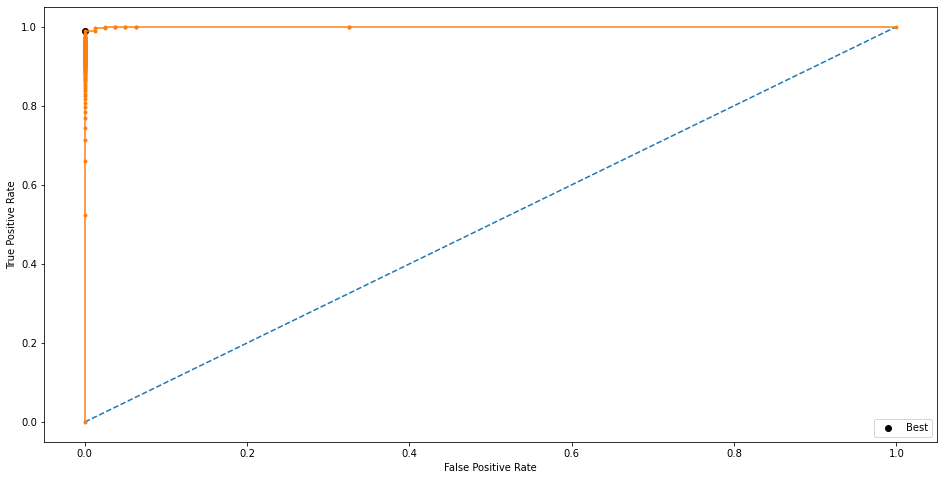

In [39]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

The bigger area below the curve the better, here curve is almost ideal.

Creating precision-recall curve

In [40]:
precision, recall, thresholds = metrics.precision_recall_curve(y_valid,preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]}')

Best Threshold=0.6656601428985596, F-Score=0.9998115814596156


Optimal threshold for precision-recall curve.

F-Score = (2 * Precision * Recall) / (Precision + Recall)

Ploting the curve

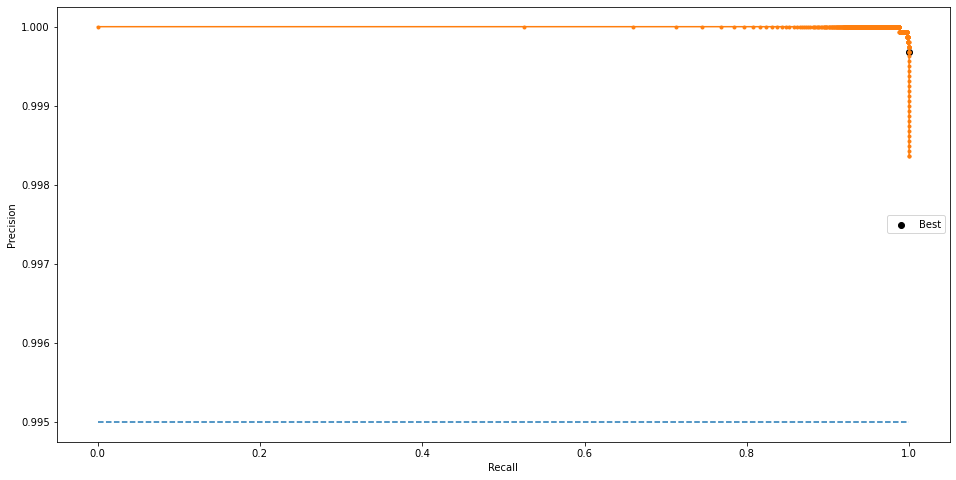

In [41]:
no_skill = len(y_valid[y_valid==1]) / len(y_valid)
plt.plot([0,1], [no_skill,no_skill], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Or by using PrecisionRecallDisplay

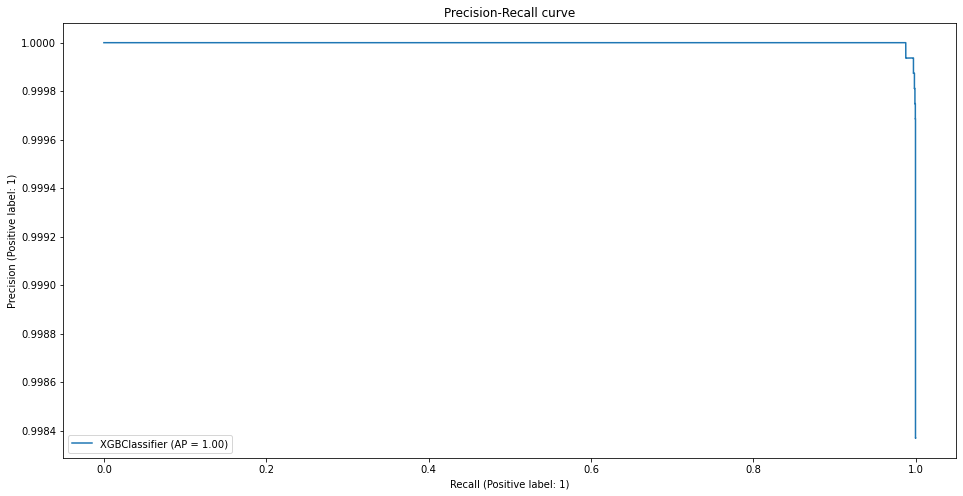

In [42]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    pipe, X_valid, y_valid, name="XGBClassifier")
_ = display.ax_.set_title("Precision-Recall curve")

Model has Average Precision(AP) = 1

Fitting optimal threshold to predictions

In [43]:


threshold = thresholds[ix]
print("Treshold:",threshold)
preds = pipe.predict_proba(X_valid)
preds = (preds[:,1] >= threshold).astype('int')
score = precision_recall_fscore_support(y_valid,preds)
print("Fscore:",score)
tn, fp, fn, tp = confusion_matrix(y_valid,preds).ravel()
print('True negatives',tn,'\nFalse positives',fp,'\nFalse negatives',fn,'\nTrue positives',tp)
print(classification_report(y_valid,preds))

Treshold: 0.66566014
Fscore: (array([0.98684211, 0.99968601]), array([0.9375    , 0.99993719]), array([0.96153846, 0.99981158]), array([   80, 15920]))
True negatives 75 
False positives 5 
False negatives 1 
True positives 15919
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        80
           1       1.00      1.00      1.00     15920

    accuracy                           1.00     16000
   macro avg       0.99      0.97      0.98     16000
weighted avg       1.00      1.00      1.00     16000



Model improved by making 3 less false positives

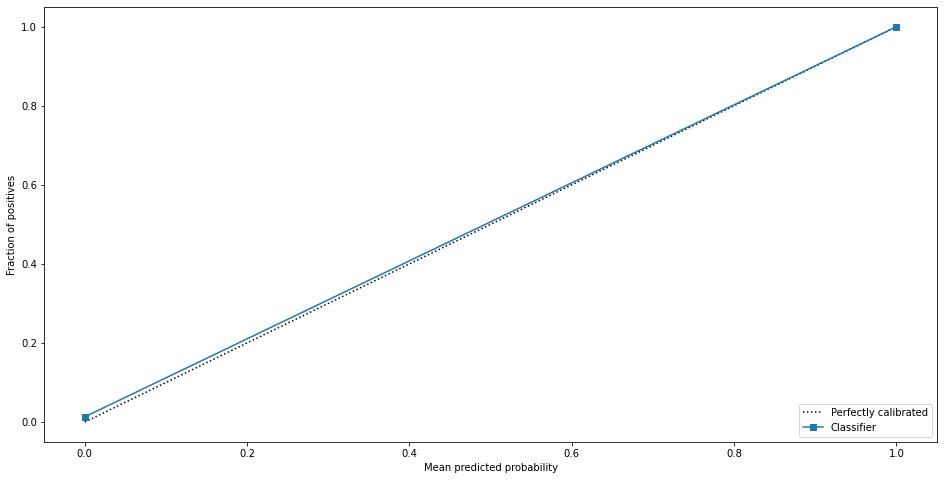

In [44]:
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_predictions(y_valid, preds)
plt.show()

Explanation using LIME

Creating array to fit into lime

In [45]:
ar_train=preprocessor.fit_transform(X_train)
onehot_names = pipe['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_cols)
colum = numerical_cols + list(onehot_names)


Preprocessing data to get a form that goes into model

In [46]:
a = preprocessor.fit(X_train)
frame = pd.DataFrame(a.transform(X_valid))
frame.rename(columns={x:colum[x] for x in range(0,len(colum))},inplace=True)

Processed validation data

In [47]:
frame.head()

,gender,time,date,site_len0,site_len1,site_len2,site_len3,site_len4,site_len5,site_len6,...,site11_Other,site11_asiafriendfinder.com,site11_couchtools.com,site11_freefaculty.org,site11_icone-gif.com,site11_pixeden.com,site11_quovadisglobal.com,site11_youtube.com,site12_None,site12_Other
0,0.0,1224.0,2306880.0,135.0,127.0,59.0,176.0,205.0,71.0,41.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,272.0,4795200.0,49.0,169.0,200.0,87.0,89.0,263.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1106.0,5114880.0,276.0,96.0,134.0,176.0,210.0,99.0,197.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,825.0,1010880.0,91.0,62.0,76.0,77.0,173.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1071.0,4561920.0,150.0,135.0,83.0,109.0,67.0,347.0,327.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Creating explainer

In [68]:
explainer = lime_tabular.LimeTabularExplainer(ar_train, # X_train as an array
                                              mode="classification", # we are doing classification not regression                                             
                                              class_names=['Joe','Not Joe'], # class names for prediction
                                              feature_names=colum # columns names from onehot encoded data
                                             )

Chosing random number

In [49]:
idx = random.randint(0, len(X_valid))
idx

7803

Checking is random value was Joe or not Joe

In [50]:
y_valid.iloc[idx]

1

In [71]:
explanation = explainer.explain_instance(frame.iloc[idx], model.predict_proba,num_features=30)

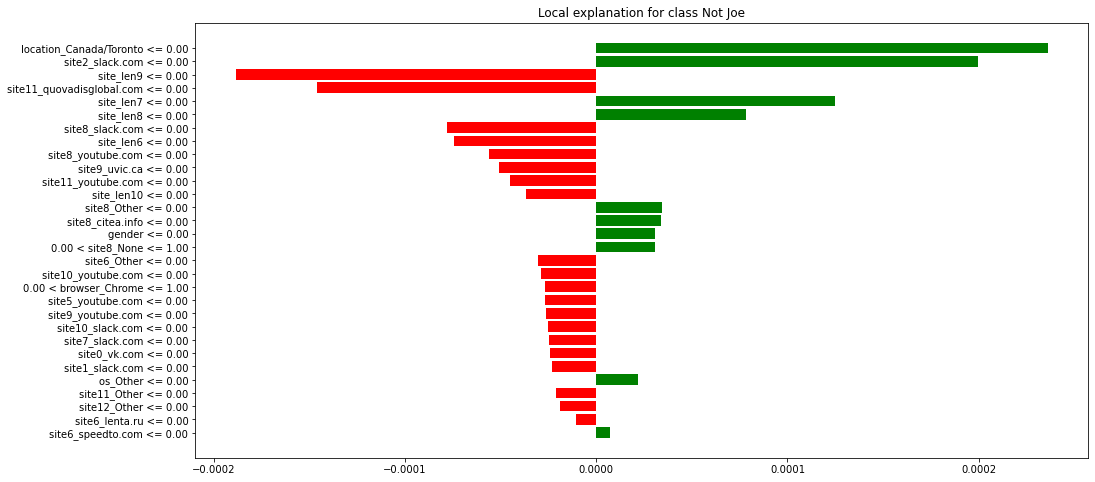

In [65]:

fig = explanation.as_pyplot_figure()

Green bars that go right says that this features reduces probability that is is Joe, and red that go left says that this features improve a chance for this user being a Joe

In [53]:
list(y_valid).index(0)

34

In [54]:
y_valid.iloc[34]

0

User number 34 is a Joe

In [69]:
explanation_joe = explainer.explain_instance(frame.iloc[34], model.predict_proba,num_features=30)

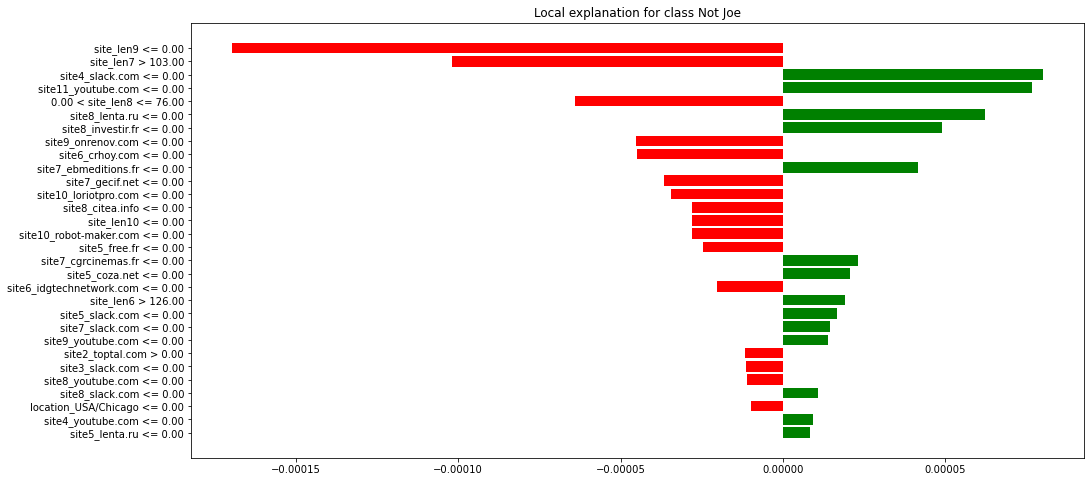

In [73]:
fig_joe = explanation_joe.as_pyplot_figure()

In [57]:
predictions = pipe.predict_proba(X_test)
predictions = (predictions[:,1] >= threshold).astype('int')

In [58]:
joes = len(predictions)-predictions.sum()
not_joes = predictions.sum()
print("Predictions for test data:\nNumber of users model detected Joe:",joes,'\nNumber of users that according to model are not Joe',not_joes)

Predictions for test data:
Number of users model detected Joe: 69 
Number of users that according to model are not Joe 22631
